In [3]:
%pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [4]:
import kagglehub

path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Here is my path to the dataset", path)

100%|██████████| 11.4M/11.4M [00:00<00:00, 19.7MB/s]

Extracting files...


Here is my path to the dataset /Users/manyajain/.cache/kagglehub/datasets/amananandrai/ag-news-classification-dataset/versions/2


In [5]:
import pandas as pd
import os


print(os.listdir(path))

val = pd.read_csv(os.path.join(path, "train.csv"))


val.head()  

['test.csv', 'train.csv']


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
#1
import os
import pandas as pd

pathused = os.path.join(path, "train.csv")
val = pd.read_csv(pathused)

val.columns = ["label_raw", "title", "description"]



val["text"] = val["title"].fillna("") + " " + val["description"].fillna("")

val["label"] = val["label_raw"] - 1

val[["label", "text"]].head()

,label,text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [10]:
#2
%pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

xVal_text, xtestval_text, y_train, y_test = train_test_split(
    val["text"],
    val["label"],
    test_size=0.2,
    random_state=42,
    stratify=val["label"],
)

vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english",
)

xVal = vectorizer.fit_transform(xVal_text)
xtestval = vectorizer.transform(xtestval_text)


Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import pandas as pd 

classes = np.unique(y_train)

def iterationFunction(X, y, batch_size=256, shuffle=True):
    n = X.shape[0]
    indices = np.arange(n)
    if shuffle:
        np.random.shuffle(indices)

    if isinstance(y, pd.Series):
        y_arr = y.to_numpy()
    else:
        y_arr = np.asarray(y)

    for start in range(0, n, batch_size):
        batch_idx = indices[start:start + batch_size]
        yield X[batch_idx], y_arr[batch_idx]

class_names = {0: "World", 1: "Sports", 2: "Business", 3: "SciTech"}

diag_words = {
    "government": 0,
    "soccer": 1,
    "stock": 2,
    "space": 3,
}

vocab = vectorizer.vocabulary_
diag_indices = {}
for w in diag_words:
    idx = vocab.get(w)
    if idx is None:
        print(f"Single word '{w}' not in vocabulary")
    diag_indices[w] = idx

common_words = ["news", "said", "new", "today"]
world_words = ["government", "president", "minister", "war", "iraq"]
sports_words = ["game", "team", "season", "coach", "soccer"]
business_words = ["market", "company", "stock", "shares", "profit"]
scitech_words = ["technology", "software", "internet", "research", "space"]

lexical_sets = {
    "common":   {"class": None, "words": common_words},
    "world":    {"class": 0,    "words": world_words},
    "sports":   {"class": 1,    "words": sports_words},
    "business": {"class": 2,    "words": business_words},
    "scitech":  {"class": 3,    "words": scitech_words},
}

lexical_set_indices = {}
for set_name, info in lexical_sets.items():
    indices = []
    for w in info["words"]:
        idx = vocab.get(w)
        if idx is None:
            print(f"Set '{set_name}': word '{w}' not in vocabulary")
        else:
            indices.append(idx)
    lexical_set_indices[set_name] = indices


In [13]:
import numpy as np

X_by_class = {}
y_by_class = {}
y_train_array = y_train.to_numpy()

for c in classes:
    idx = np.where(y_train_array == c)[0]
    X_by_class[c] = xVal[idx]
    y_by_class[c] = y_train_array[idx]

clf_massed = SGDClassifier(loss="log_loss", random_state=0)
massed_acc = []

massed_word_coefs = {w: [] for w in diag_words}
massed_set_coefs = {name: [] for name in lexical_sets}

n_epochs = 5
step = 0

for epoch in range(n_epochs):
    print(f"Massed epoch {epoch + 1}/{n_epochs}")
    for c in classes:
        Xc = X_by_class[c]
        yc = y_by_class[c]
        for Xb, yb in iterationFunction(Xc, yc, batch_size=256, shuffle=True):
            if step == 0:
                clf_massed.partial_fit(Xb, yb, classes=classes)
            else:
                clf_massed.partial_fit(Xb, yb)

            y_pred = clf_massed.predict(xtestval)
            massed_acc.append(accuracy_score(y_test, y_pred))

            for w, cls_id in diag_words.items():
                idx = diag_indices[w]
                if idx is not None:
                    coef_val = clf_massed.coef_[cls_id, idx]
                    massed_word_coefs[w].append(coef_val)

            for set_name, info in lexical_sets.items():
                idx_list = lexical_set_indices[set_name]
                if len(idx_list) == 0:
                    massed_set_coefs[set_name].append(np.nan)
                    continue

                if info["class"] is None:
                    coefs = clf_massed.coef_[:, idx_list]
                    avg_val = np.mean(np.abs(coefs))
                else:
                    cls_id = info["class"]
                    coefs = clf_massed.coef_[cls_id, idx_list]
                    avg_val = np.mean(coefs)

                massed_set_coefs[set_name].append(avg_val)

            step += 1


Massed epoch 1/5
Massed epoch 2/5
Massed epoch 3/5
Massed epoch 4/5
Massed epoch 5/5


In [15]:
clf_inter = SGDClassifier(loss="log_loss", random_state=0)
inter_acc = []

inter_word_coefs = {w: [] for w in diag_words}
inter_set_coefs = {name: [] for name in lexical_sets}

n_epochs = 5
step = 0

for epoch in range(n_epochs):
    print(f"Interleaved epoch {epoch + 1}/{n_epochs}")
    for Xb, yb in iterationFunction(xVal, y_train_array, batch_size=256, shuffle=True):
        if step == 0:
            clf_inter.partial_fit(Xb, yb, classes=classes)
        else:
            clf_inter.partial_fit(Xb, yb)

        y_pred = clf_inter.predict(xtestval)
        inter_acc.append(accuracy_score(y_test, y_pred))

        for w, cls_id in diag_words.items():
            idx = diag_indices[w]
            if idx is not None:
                coef_val = clf_inter.coef_[cls_id, idx]
                inter_word_coefs[w].append(coef_val)

        for set_name, info in lexical_sets.items():
            idx_list = lexical_set_indices[set_name]
            if len(idx_list) == 0:
                inter_set_coefs[set_name].append(np.nan)
                continue

            if info["class"] is None:
                coefs = clf_inter.coef_[:, idx_list]
                avg_val = np.mean(np.abs(coefs))
            else:
                cls_id = info["class"]
                coefs = clf_inter.coef_[cls_id, idx_list]
                avg_val = np.mean(coefs)

            inter_set_coefs[set_name].append(avg_val)

        step += 1


Interleaved epoch 1/5
Interleaved epoch 2/5
Interleaved epoch 3/5
Interleaved epoch 4/5
Interleaved epoch 5/5


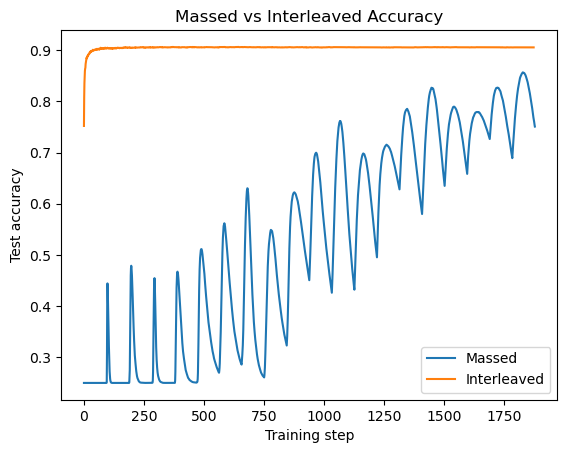

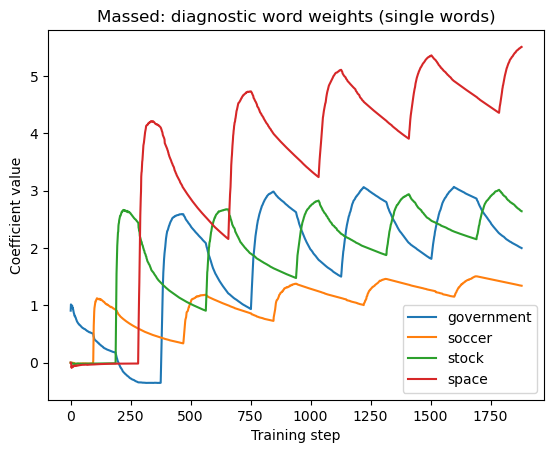

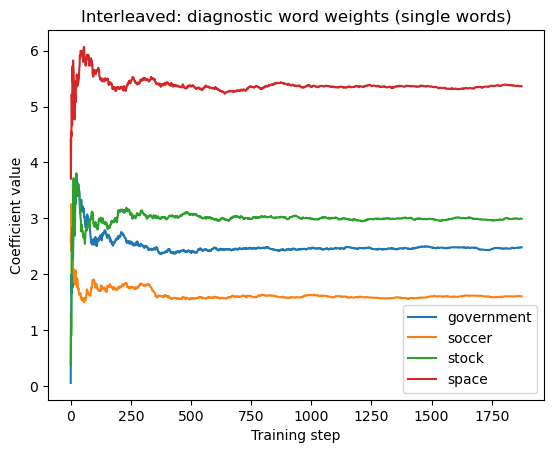

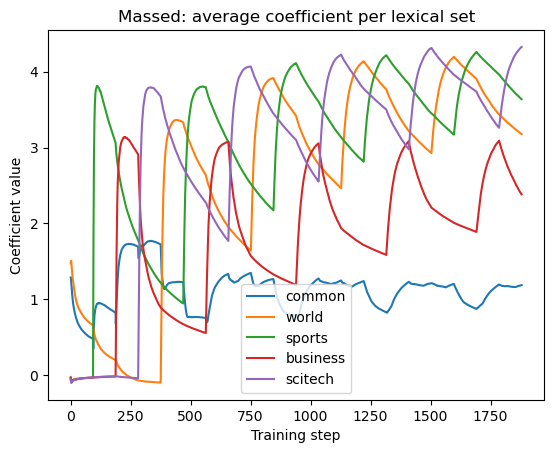

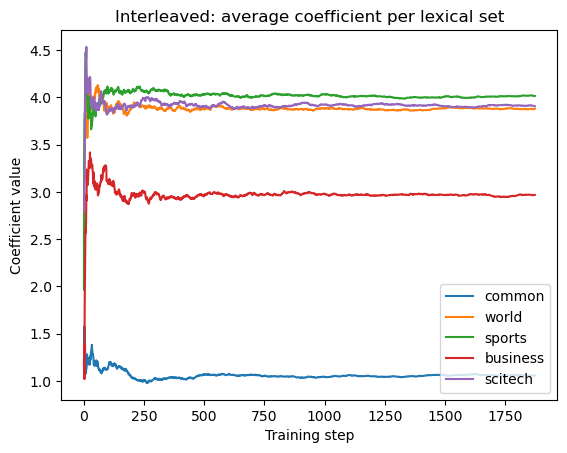

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(massed_acc, label="Massed")
plt.plot(inter_acc, label="Interleaved")
plt.xlabel("Training step")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Massed vs Interleaved Accuracy")
plt.show()

def plot_history(history, title):
    plt.figure()
    for name, vals in history.items():
        if len(vals) == 0:
            continue
        arr = np.array(vals, dtype=float)
        plt.plot(arr, label=name)
    plt.xlabel("Training step")
    plt.ylabel("Coefficient value")
    plt.legend()
    plt.title(title)
    plt.show()

plot_history(massed_word_coefs, "Massed: diagnostic word weights (single words)")
plot_history(inter_word_coefs, "Interleaved: diagnostic word weights (single words)")

plot_history(massed_set_coefs, "Massed: average coefficient per lexical set")
plot_history(inter_set_coefs, "Interleaved: average coefficient per lexical set")
